# Machine Learning Capstone Project

Fist we have to import the dependecies needed for the project as specified by the [README](https://github.com/jeyvison/machine_learning_project/blob/master/README.md) file

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from IPython.display import display 
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
import visuals as vs
from sklearn.metrics import f1_score

# Pretty display for notebooks
%matplotlib inline

print 'Dependencies succefully imported'

Dependencies succefully imported


In [2]:
#Loading the trainning data
data = pd.read_csv('data.csv')

#Removing unnecessary id column
data.drop(['id','Unnamed: 32'],1,inplace=True)

X = data.drop('diagnosis',1)
y = data.drop(X,1)

print 'Dataset succefully loaded. {0} points and {1} features'.format(*X.shape)

Dataset succefully loaded. 569 points and 30 features


Since we are in a high dimensional feature space we must check which features have more importance on this dataset so we can performe a feature reduction.

In [3]:
#First, we scale the dataset with the log function
X = np.log(X)

#We had some 0 values in our dataset that were turned to 'inf'
#Now we have to change it back
X[np.isinf(X)] = 0.0

display(X.describe())

/home/jeyvison/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,2.619131,2.935269,4.489174,6.363185,-2.350210,-2.380518,-2.777267,-3.237934,-1.719430,-2.773718,...,2.749578,3.217009,4.631289,6.615811,-2.037005,-1.550372,-1.592779,-2.266666,-1.258202,-2.497773
std,0.238189,0.220789,0.251084,0.483139,0.145572,0.494459,1.145741,0.981372,0.148229,0.106867,...,0.276438,0.240730,0.290892,0.554917,0.173086,0.617256,1.001406,0.723568,0.200010,0.195784
min,1.943192,2.273156,3.779405,4.966335,-2.944469,-3.943514,-7.275925,-6.291489,-2.244316,-2.996533,...,2.070653,2.486572,3.920190,5.221436,-2.642684,-3.601235,-6.295276,-4.736190,-1.854699,-2.899695
25%,2.459589,2.783158,4.319752,6.040969,-2.449115,-2.734600,-3.462222,-3.859905,-1.820776,-2.852498,...,2.565718,3.048325,4.432125,6.244749,-2.149006,-1.915963,-2.085862,-2.703660,-1.384696,-2.638617
50%,2.593013,2.935982,4.457134,6.311916,-2.344762,-2.379142,-2.708450,-3.296837,-1.719253,-2.788068,...,2.706048,3.235143,4.581492,6.531606,-2.030270,-1.551641,-1.421714,-2.256656,-1.265139,-2.525229
75%,2.758743,3.081910,4.645352,6.662749,-2.250942,-2.037149,-1.976885,-2.543765,-1.631172,-2.716284,...,2.933325,3.391820,4.831509,6.988413,-1.924149,-1.081460,-0.922309,-1.767262,-1.146018,-2.385098
max,3.336125,3.670715,5.239098,7.824446,-1.811554,-1.063052,0.000000,0.000000,-1.190728,-2.328518,...,3.584629,3.902780,5.526249,8.355615,-1.502379,0.056380,0.224742,0.000000,-0.409774,-1.572624


Now that we scaled the data lets analyze it

In [47]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=9)
# pca.fit(X)

# pca_results = vs.pca_results(X, pca)

def scorer(estimator,X,y):
    
    predicted = estimator.predict(X)
    
    return f1_score(y, predicted, pos_label='B')

svc = SVC(kernel="linear",random_state=52)

stratifiedKFold = StratifiedKFold(n_splits=10,shuffle=True,random_state=30)

rfecv = RFECV(estimator=svc, step=1, cv=stratifiedKFold,
              scoring=scorer,verbose=True)

rfecv.fit(X,y)

print 'Features selected'

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.

Now that we have

Optimal number of features : 15


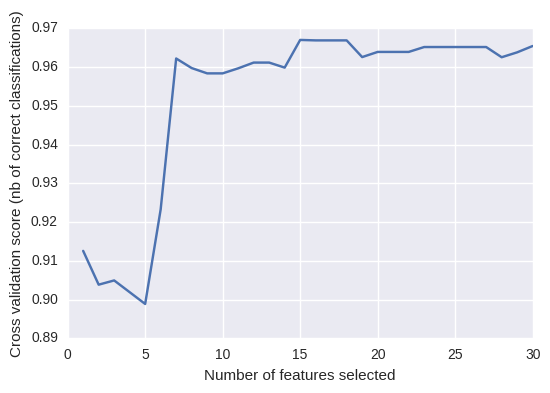

Max score found:0.96700567336


In [45]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print 'Max score found:' +  str(max(rfecv.grid_scores_))

# pca = PCA(n_components=9)

# reduced_data = pca.fit_transform(X)

# new_X = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3', 'Dimension 4','Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8','Dimension 9'])

# display(new_X.describe())

Now we reduced our data we must find the best score for the possible component numbers.

In [49]:
print rfecv.transform(X)
print rfecv.score(X,y)

[[ 17.99      0.1184    0.2776  ...,   0.7119    0.2654    0.4601 ]
 [ 20.57      0.08474   0.07864 ...,   0.2416    0.186     0.275  ]
 [ 19.69      0.1096    0.1599  ...,   0.4504    0.243     0.3613 ]
 ..., 
 [ 16.6       0.08455   0.1023  ...,   0.3403    0.1418    0.2218 ]
 [ 20.6       0.1178    0.277   ...,   0.9387    0.265     0.4087 ]
 [  7.76      0.05263   0.04362 ...,   0.        0.        0.2871 ]]
0.959578207381
